The purpose of this short exercise is to explore the intricacies of temperature timeseries and their role in the pricing of temperature-contingent claims such as a HDD contract $C_0$ defined by:

<h1><center>$C\propto \max(T-K,0)$</center></h1>
where K denotes the strike of the contract (canonically $K=18^{\circ}C=65^{\circ}F$ for so-called heating-degree contracts (HDD).
The Notebook is inspired by the work of (Alexandridis, Zapradis) in their book "Weather Derivatives" published by Springer. As a datasource we use freely available temperature data of the Frankfurt airport supplied by the German weather agency. 

In [24]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
random.seed(0)
from scipy.stats import norm
from os import getcwd
    




pwd = getcwd()
path = pwd+'/Frankfurt.txt'
df = pd.read_csv(path,delimiter=';')
    
df.head()


,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,1420,19490101,-999,-999.0,-999.0,5,4.3,1,-999.0,0,8.0,6.3,977.2,6.6,65.0,9.2,1.5,1.0,eor
1,1420,19490102,-999,-999.0,-999.0,5,2.3,1,-999.0,0,8.0,6.9,981.8,2.4,94.0,7.1,0.5,2.2,eor
2,1420,19490103,-999,-999.0,-999.0,5,0.1,1,-999.0,0,5.0,6.4,993.1,2.0,88.0,5.0,0.1,-0.3,eor
3,1420,19490104,-999,-999.0,-999.0,5,0.0,1,-999.0,0,6.7,5.6,1000.4,2.4,78.0,3.7,-1.6,-3.4,eor
4,1420,19490105,-999,-999.0,-999.0,5,0.0,1,-999.0,0,8.0,6.7,1011.2,3.5,86.0,5.3,1.6,1.2,eor


In [5]:
df = df[["MESS_DATUM"," TMK"]]
df["MESS_DATUM"]=df["MESS_DATUM"].apply(lambda x: str(x)).apply(lambda x: x[0:4]+"-"+x[4:6]+"-"+x[-2:])
df.head()

,MESS_DATUM,TMK
0,1949-01-01,6.6
1,1949-01-02,2.4
2,1949-01-03,2.0
3,1949-01-04,2.4
4,1949-01-05,3.5


0

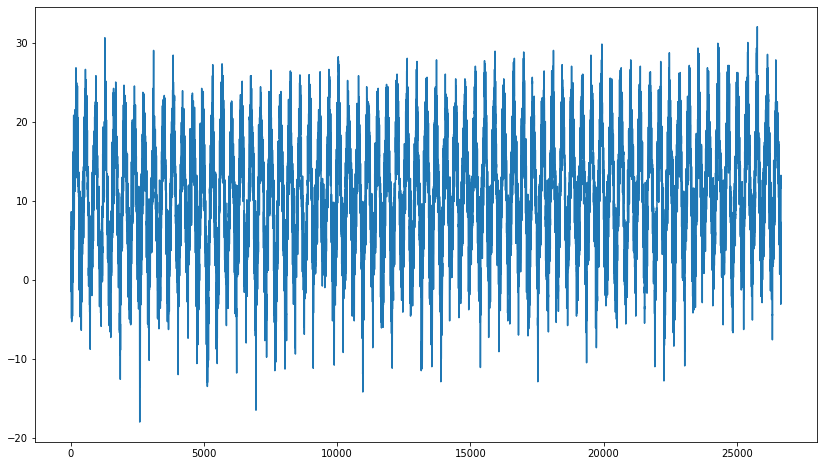

In [6]:
plt.figure(figsize=(14,8))
plt.plot(df[' TMK'])
df[' TMK'].isna().sum()

The dateset seems to be free from outliers. We will thus abstain from applying a filter to clean the data in this respect. Now let's detrend the data. We fit a data based off the linear trend 
<h1><center>$T_t^m=a+bt+c\sin(\omega t+\phi)$</center></h1>
 where $\omega = \frac{2\pi}{365.25}$ (Accounting for leap years). The detrended and deseasonalized data then reads $\bar{T}=T-Y$
 Note that in literature (Alexandridis, Zapranis - Weather Derivatives), more elaborate methods for detrending exist (finite Fourier Series, Wavelet Analysis, Wavelet Networks). We fit the model first with a global optimization algorithm (basin hopping) and later check with a local optimizer how much computing power we wasted by using the global optimizer ;)

In [7]:
def t_trend(x,a,b,c,phi):
    """
    returns the linear model formulated above
    """
    omega=2*np.pi/365.25
    return a+b*x+c*np.sin(omega*x+phi)


#this is just to check if "global" optimizer delivers similar results to local least squares
def wrapper_lsq(params):
    """
    params[0]=a
    params[1]=b
    params[2]=c
    params[3]=phi
    wrapper function for lsq optimization which is later passed to basin hopping algorithm which globally optimizes parameters of linear model with seasonal trend
    with respect to mean square distance to actual ts - later compare to denoised process!
    """
    x = np.arange(len(df))
    t_pred = t_trend(x,params[0],params[1],params[2],params[3])
    return np.sqrt((df[' TMK']-t_pred)**2).sum()
    
initial_guess = [10,0.001,20,0.1]

from scipy.optimize import basinhopping

class RandomDisplacementBounds(object):
    """
    random displacement with bounds:  see: https://stackoverflow.com/a/21967888/2320035
    """

    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds """
        min_step = np.maximum(self.xmin - x, -self.stepsize)
        max_step = np.minimum(self.xmax - x, self.stepsize)

        random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        xnew = x + random_step

        return xnew

minimizer_kwargs = {"method": "L-BFGS-B"}

b_a = (-10, 10)
b_b = (0.0001, 0.01)
b_c = (-50, 50)
b_phi = (-np.pi/2, np.pi/2)

bounds = [b_a, b_b, b_c, b_phi]

bounded_step = RandomDisplacementBounds(
    np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
)


result = basinhopping(wrapper_lsq, initial_guess,niter=200, minimizer_kwargs = minimizer_kwargs,take_step=bounded_step)


[ 9.05945043e+00  8.78278859e-05  9.05632152e+00 -1.81730451e+00]
Optimization terminated successfully.
         Current function value: 77138.251360
         Iterations: 333
         Function evaluations: 569


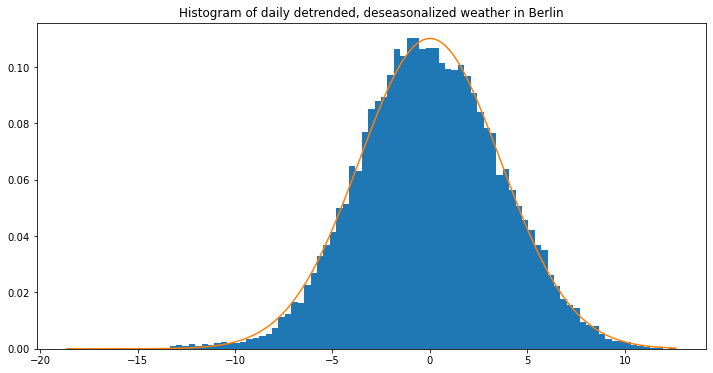

In [9]:
params = result.x
print(params)
x=np.arange(len(df))

from scipy.optimize import minimize,curve_fit
res = minimize(wrapper_lsq, initial_guess, method='nelder-mead', options={'xatol': 1e-8, 'disp': True}) #zum backtesten
df["detrended"] = df[' TMK']-t_trend(x,params[0],params[1],params[2],params[3])
df["detrended"] = df["detrended"]-df["detrended"].mean()

plt.figure(figsize=(12,6))
plt.hist(df.detrended,bins="auto",density=True)
plt.title("Histogram of daily detrended, deseasonalized weather in Berlin")
#Test if Gaussian can be fitted to data

mu, std = norm.fit(df.detrended)

xrange=np.linspace(start=min(df.detrended),stop=max(df.detrended),num=len(df))
plt.plot(xrange,norm.pdf(xrange, mu, std))


It is not far fetched to assume that the above data is distributed according to a Gaussian distribution (however the data seems to be skewed to the left). We will analyze with statistical test, in how far the normality hypothesis can be proved. We will start with a descriptive statistical test. (QQ Plot)

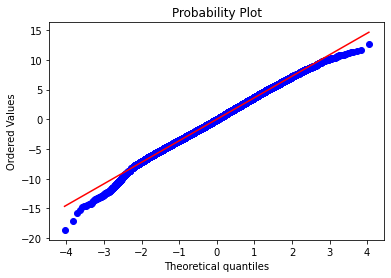

In [10]:
from scipy import stats
import pylab
#qqplot
stats.probplot(df.detrended,dist="norm",plot=pylab)
pylab.show()

The qq Plot agrees with the above observation that the tails are overemphasized in the sample in order to come from a Gaussian distribution. This might be quantified with the Jarque-Bera test statistic, reading 
<h1><center>$\begin{equation}
JB=\frac{n}{6}\left(S^2+\frac{1}{4}(K-3)^2\right)
\end{equation}$</center></h1>
with n being the sample size, S being the sample skewness and K being the sample kurtosis. Note that the moments of a centered Gaussian random variable $X\sim N(0,1)$ read $E(X^n)=\sigma^n(n-1)!!$, such that for the kurtosis we have $E(X^4)=3$ and for the skewness $S=E(X^3)=0$

In [11]:
hist,_ = np.histogram(df.detrended)
statistic = stats.jarque_bera(hist)
print("statistic = %.3f, p-value=%.3f \n" %(statistic.statistic,statistic.pvalue))

statistic = 1.490, p-value=0.475 



It seems that the Null Hypothesis holds (see p-value). However can we do better? But what about the distribution of the first differences? After all, in the stochastic modelling of future temperatures, we most likely will opt for a SDE as suggested in (Alexandridis, Zapranis). SDEs essentially determine the dynamics of infinitesimal differences, often driven by Brownian motion. If we could show, that the first difference (which can approximately be seen as infinitesimal differences) obey a normal distribution too, a SDE driven by Brownian motion could be considered as a process for the temperature process. 

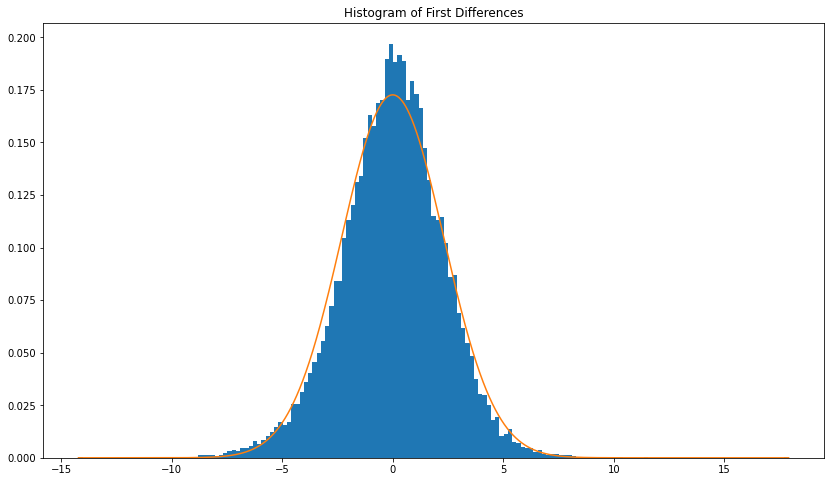

In [12]:
df["FirstDiff"]=df.detrended.diff()
plt.figure(figsize=(14,8))
plt.hist(df.FirstDiff,bins="auto",density=True)
plt.title("Histogram of First Differences")

xrange=np.linspace(start=min(df.FirstDiff.dropna()),stop=max(df.FirstDiff.dropna()),num=len(df))
mu,std = stats.norm.fit(df.FirstDiff.dropna())

plt.plot(xrange,stats.norm.pdf(xrange,mu,std))

We proceed with the same statistical tests as above.

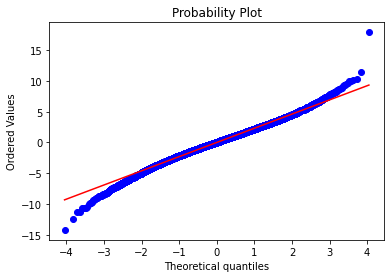

statistic = 6.858, p-value=0.032 



In [13]:
stats.probplot(df.FirstDiff.dropna(),dist="norm",plot=pylab)
pylab.show()

hist,_=np.histogram(df.FirstDiff.dropna())
statistic = stats.jarque_bera(hist)
print("statistic = %.3f, p-value=%.3f \n" %(statistic.statistic,statistic.pvalue))


Apparently the tails of the model still carry too much weight for them to be properly described by a normal distribution. Still, the distribution seems more symmetric as the original distribution.This stabilizes the mean in the simulation. Thus a model for average temperatures might very well be described by a stochastic process driven by Brownian motion. Next we have to incorporate the apparent seasonality into our SDE. It is straightforward to consider a mean reverting Ornstein-Uhlenbeck process for the (daily average) Temperature:
<h1><center>$\begin{equation}
dT_t=\kappa(\bar{T}_t^m-T_t)dt+\sigma_tdW_t
\end{equation}$</center></h1>

Note that the mean temperature is time dependent, too. This artifact however leads to the above model not having the long-term mean $\bar{T}_t^m$ (see Alexandridis, Zapranis). We motivate this with the Ito Formula to solve the above SDE. We make use of the integrating factor $e^(\kappa t)$:
<h1><center>
$\begin{align}
d(e^{\kappa t}T_t)&=\kappa e^{\kappa t}T_t dt+e^{\kappa t}dT_t\\
&=\kappa e^{\kappa t}\bar{T}_t^mdt+e^{\kappa t}\sigma_tdW_t
\end{align}$
</center></h1>
Integrating above expression from $s$ to $t$ yields:

<h1><center>
$\begin{align}
e^{\kappa t}T_t&=e^{\kappa s}T_s+\int_s^t\kappa e^{\kappa t}\bar{T}_u^mdu+\int_s^t e^{\kappa u}\sigma_udW_u\\
&=e^{\kappa s}T_s + e^{\kappa t}\bar{T}_t^m-e^{\kappa s}\bar{T}_s^m -\int_s^te^{\kappa u}d(\bar{T}_u^m)+\int_s^t e^{\kappa u}\sigma_udW_u
\end{align}$
</center></h1>
Taking the expectation on both sides does not yield the desired characteristic $\lim_{t\rightarrow\infty}\mathbb{E}(T_t)=\bar{T}_t^m$, such that we have to tweak the model a little by adjusting for the time dependency of the underlying trend process by correcting for its dynamics:

<h1><center>$\begin{equation}
dT_t=d\bar{T}_t^m+ \kappa(\bar{T}_t^m-T_t)dt+\sigma_tdW_t
\end{equation}$</center></h1>

With the same integrating factor one quickly arrives at the formula

<h1><center>$\begin{equation}
d(e^{\kappa t}(T_t-\bar{T}_t^m))=e^{\kappa t}\sigma_tdW_t
\end{equation}$</center></h1>

meaning that the temperature process indeed reverts to the trend process in the mean (since the expectation of the RHS is zero).




Next we have to estimate the remaining parameters of the model, namely the mean reversion parameter (which we assume to be constant for now) and the volatility process (which we assume to be determistic).
For $\kappa$ we make use of characteristics of the discretization of the Temperature SDE (assume $\Delta t=1$):

<h1><center>$\begin{equation}
\Delta T_t=\Delta \bar{T}_t^m + \kappa T_{t-1}-\kappa \bar{T}_{t-1}^m +\sigma(t-1)\Delta W(t)
\end{equation}$</center></h1>

By identifying the detrended Temperature with $\tilde{T_t}$ and by making use of $\Delta W(t)=Z\sqrt{t}\equiv \epsilon(t)$ with $Z\sim N(0,1)$ we can reduce above expression to a AR(1) process for the detrended temperature:

<h1><center>$\begin{equation}
\tilde{T_t}=(1+\kappa)\tilde{T_t} + \sigma(t-1)\epsilon(t)
\end{equation}$</center></h1>

Thus $\kappa$ can be estimated by fitting a AR(1) model.

In [14]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(df.detrended,lags=1,trend='n').fit()
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
print(out.format(res.aic, res.hqic, res.bic))
print(res.summary())


AIC: 117480.878, HQIC: 117486.164, BIC: 117497.260
                            AutoReg Model Results                             
Dep. Variable:              detrended   No. Observations:                26663
Model:                     AutoReg(1)   Log Likelihood              -58738.439
Method:               Conditional MLE   S.D. of innovations              2.191
Date:                Wed, 23 Nov 2022   AIC                         117480.878
Time:                        21:36:53   BIC                         117497.260
Sample:                             1   HQIC                        117486.164
                                26663                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
detrended.L1     0.7965      0.004    215.101      0.000       0.789       0.804
                                    Roots                                 

The p value is nonexistent, this needs to be examined, for now we continue to work with the coefficient $\kappa=1-0.7966=0.2044$. The next task lies in the modelling of the modelling of the volatilities. We first look at the volatility of the volatility in a descriptive manner:

<AxesSubplot:>

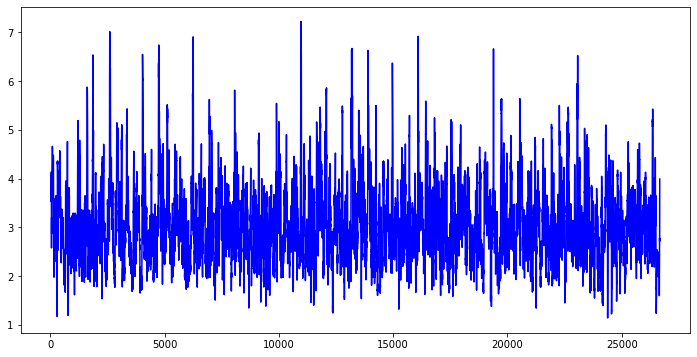

In [15]:
plt.figure(figsize=(12,6))
df.detrended.rolling(window=30).std().plot(style='b')

We first want to check if there are signigicant regime-changes in the mean of the variance-process. To do this, we convolve the above process with a step function and check where the max of this convolution is located.

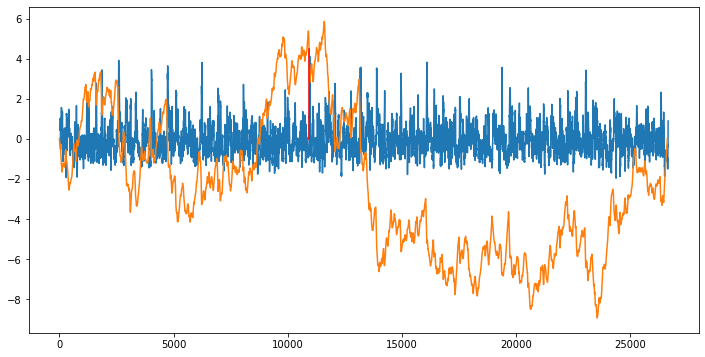

In [16]:
data  = df.detrended.rolling(window=30).std().dropna()
data -= data.mean()

step = np.hstack((np.ones(len(data)), -1*np.ones(len(data))))

data_step = np.convolve(data, step, mode='valid')

# get the peak of the convolution, its index

step_indx = np.argmax(data)  # yes, cleaner than np.where(dary_step == dary_step.max())[0][0]

# plots

plt.figure(figsize=(12,6))
plt.plot(data)

plt.plot(data_step/100)

plt.plot((step_indx, step_indx), (data_step[step_indx]/100, 0), 'r')



The idea of this method was to look for the maximum of the convolution with a (-1,1)-step function. In time series with exactily one regime-shift, this maximum coincides with the location of the shift. Note that due to the rescaling to mean zero, the convolution with the step function is similar to taking cumulative sums of the underlying process (weighted with the respective sign). The above analysis however does not indicate a unique shift. We must dig a little deeper by making use of more elaborate step-detection algorithms. Maybe a Gaussian Mixture Model can extract signals on hidden states in the timeseries?

Text(0.5, 0, 'n_components')

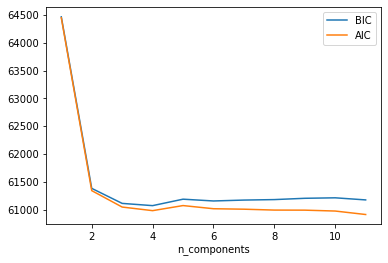

In [17]:
from datetime import datetime
df["date"]=df.MESS_DATUM.apply(lambda x: str(x)).apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
df["vola"]=df.detrended.rolling(window=30).std()
df_1 = df[["date","detrended","vola"]].drop(range(0,31)) # drop first month since this was "burn-in" of vola
df_1.head()

#GaussianMixture Model to check for Regime Switches
from sklearn.mixture import GaussianMixture

X = np.array(df_1.vola).reshape(-1,1)

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Maybe the observations on different regimes are influenced by too much noise. We thus analyse subsets of the data and/or denoise the data. For Denoising the signal we use the Savitzy-Golay Filter of Scipy, which denoises the data by applying a smoothing convolution

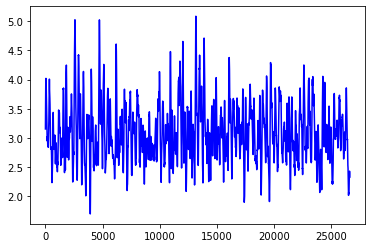

In [18]:
from scipy.signal import savgol_filter
w = savgol_filter(df_1.vola, window_length = 181, polyorder=3)
plt.plot(w, 'b')  # high frequency noise removed

There seems to be some oscillation, to get a better feeling for it though, we filter out a smaller subset of years (currently the ts encompasses more than 70 years, thus possible yearly oscillations are squeezed too tightly)

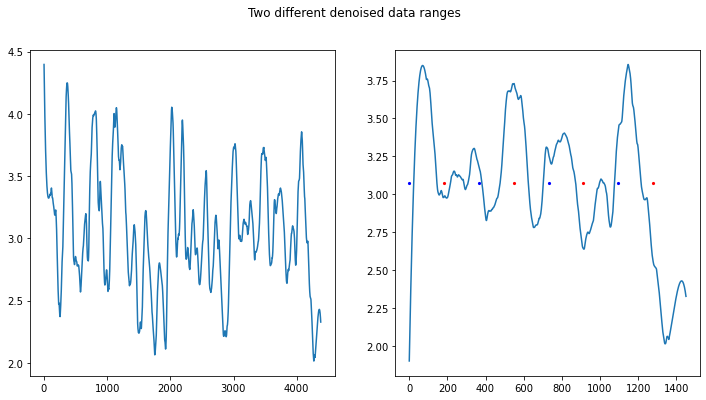

In [19]:
df_1.head()
df_1_filtered = df_1.query('date>20100101')
#plt.plot(df_1_filtered.vola)
w = savgol_filter(df_1_filtered.vola, window_length = 181, polyorder=3)
df_1_filtered = df_1.query('date>20180110')
w1 = savgol_filter(df_1_filtered.vola, window_length = 181, polyorder=3)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
fig.suptitle('Two different denoised data ranges')
ax1.plot(w)
ax2.plot(w1)
#mark the seasons with dots
col=[]
len_seasons = int(np.floor(len(df_1_filtered)/182.625))+1 #182.625 days is half a year (accounting for leap years)
xrange=np.arange(len(df_1_filtered))
for i in range(len_seasons):
    if i%2==0: # we start with winter
        col.append('blue')  
    else:
        col.append('red') 
  
for i in range(len_seasons):
      
    # plotting the corresponding x with y 
    # and respective color
    ax2.scatter(np.floor(i*182.625), np.mean(w1), c = col[i], s = 10,
                linewidth = 0)

The 12 year timeframe still seems noise (with a denoising window of 1/2 a year!). However the right plot (timeframe 3 years, denoising window 1/2 year) suggests, that (intuitively), the vola should have a seasonal character (with avg vola in winter (start of winter (Oct-Mar) labelled in blue, being higher than in summer (Apr-Sep) (begin labelled in red). Can the Gaussian mixture model confirm this?

Text(0.5, 0, 'n_components')

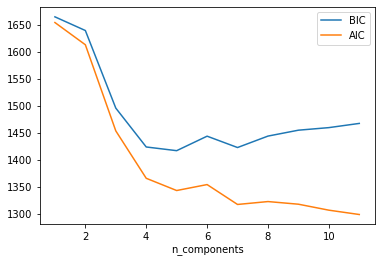

In [20]:
X = np.array(w1).reshape(-1,1)

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Due to the kinks in the beginning and the end the Gaussian Mixture model might indicate that there are 4 hidden state, lets additionally erase them and check the results afterwards.

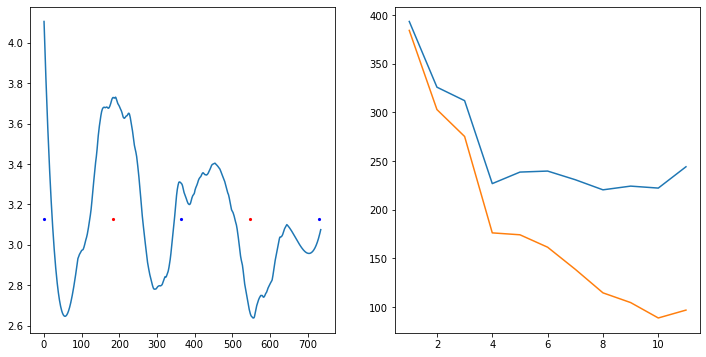

In [21]:
df_1_filtered = df_1.query('date>20190104 and date<20210110')
w1 = savgol_filter(df_1_filtered.vola, window_length = 181, polyorder=3)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))


ax1.plot(w1)

#mark the seasons with dots
col=[]
len_seasons = int(np.floor(len(df_1_filtered)/182.625))+1 #182.625 days is half a year (accounting for leap years)
xrange=np.arange(len(df_1_filtered))
for i in range(len_seasons):
    if i%2==0: # we start with winter
        col.append('blue')  
    else:
        col.append('red') 
  
for i in range(len_seasons):
      
    # plotting the corresponding x with y 
    # and respective color
    ax1.scatter(np.floor(i*182.625), np.mean(w1), c = col[i], s = 10,
                linewidth = 0)

X = np.array(w1).reshape(-1,1)

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

ax2.plot(n_components, [m.bic(X) for m in models], label='BIC')
ax2.plot(n_components, [m.aic(X) for m in models], label='AIC')


In [22]:
summer_months = [12,1,2]
winter_months = [6,7,8]
spring_months = [3,4,5]
autumn_months = [9,10,11]
df_summer = df_1[df_1['date'].dt.month.isin(summer_months)]
df_winter = df_1[df_1['date'].dt.month.isin(winter_months)]
df_spring = df_1[df_1['date'].dt.month.isin(spring_months)]
df_autumn = df_1[df_1['date'].dt.month.isin(autumn_months)]
print("summer_vola =%.2f Spring Vola = %.2f Autumn Vola=%.2f Winter Vola = %.2f " % (df_summer.vola.mean(),df_spring.vola.mean(),df_autumn.vola.mean(),df_winter.vola.mean()))


summer_vola =3.53 Spring Vola = 3.18 Autumn Vola=2.68 Winter Vola = 3.02 


Ok so since the denoised data on a shorter timeframe also suggests 4 hidden states, it is a good bet to identify these 4 hidden states with the seasons of the year. To not overcomplicate it for now we assume the vols to be constant throughout the season. We thus pass the constant volas per season to our dataframe

In [23]:
df_1["denoised_vola"]= savgol_filter(df_1.vola, window_length = 181, polyorder=3)

summer=np.array([df_summer.vola.mean() if a.month in summer_months else 0 for a in df_1['date']])
spring=np.array([df_spring.vola.mean() if a.month in spring_months else 0 for a in df_1['date']])
autumn=np.array([df_autumn.vola.mean() if a.month in autumn_months else 0 for a in df_1['date']])
winter=np.array([df_winter.vola.mean() if a.month in winter_months else 0 for a in df_1['date']])

df_1["vola_process"] = summer+spring+autumn+winter


Based on the assumptions explained above we now have estimates for $\sigma(t)$ and $\kappa$. To price a weather derivative contract $C_0$ we next need to derive a risk-neutral measure, such that we can compute the fair value of the contract by Monte Carlo simulation of the payouts of the contract given our calibrated temperature process under the risk neutral measure. 
Since Temperature is not a tradeable asset, we have to introduce a market price of risk in order to derive a risk neutral probability measure (there is no hedging portfolio, which replicates the payoff, the payoff thus can't be related to the "price of weather", i.e. the underlying directly. By lifitng the constraint that the payout must be replicated by tradeable assets, the possibilities to construct risk neutral equivalent probability measures $Q\sim P$ where $P$ denote the physical measure, grow ad infinitum.) The market price of risk can then be calibrated on prices of traded weather options (which however do not exist for Frankfurt). Also, it is possible to calibrate the market price of risk based on a basket of weather options on stations with a high correlation. The next best traded weather station is Amsterdam (AMS). 

In order to determine the market price of risk, we first have to introduce it to our model and then solve the SDE. Given Girsanov's Theorem (the underlying assumptions hold), we can construct an equivalent risk-neutral measure by applying the following transformation to the physical BM $W_t$:
<h1><center>
    $\tilde{W_t}=W_t-\int_0^t\theta(u)du$
</center></h1>
where $\theta(t)$, i.e. the market value of risk, is a real-valued $L^1$ function. Our model then looks as follows under the probability measure $Q(\theta)$:
<h1><center>
   $dT_t=d\bar{T}_t^m+ \kappa(\bar{T}_t^m-T_t-\sigma_t\theta(t))dt+\sigma_tdW_t$
</center></h1>
and thus:

<h1><center>
   $T_t=e^{-\kappa t}(T_0-\bar{T}_0^m)+\bar{T}_t^m-\int_0^t e^{\kappa(s-t)}\sigma_s\theta(s)ds+\int_0^t e^{\kappa (s-t)}\sigma_t dW_s $
</center></h1>